In [1]:
import argparse
import numpy as np
from numpy.linalg import inv, norm
from scipy.spatial.transform import Rotation as Rot
import pickle
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import List
import open3d as o3d
import clipperpy
import time
import json
from copy import deepcopy
import yaml

from robotdatapy.data.pose_data import PoseData
from robotdatapy.transform import transform_to_xytheta, transform_to_xyz_quat
from robotdatapy.geometry import circle_intersection
from robotdatapy.transform import T_FLURDF, T_RDFFLU
from robotdatapy import transform

from segment_track.segment import Segment
from segment_track.tracker import Tracker
from submap_align import create_submaps
from object_map_registration.object.ellipsoid import Ellipsoid
from object_map_registration.object.object import Object
from object_map_registration.object.pointcloud_object import PointCloudObject
from object_map_registration.register.dist_min_max_sim_reg import DistOnlyReg, DistVolReg, DistMinMaxPCAReg, DistCustomFeatureComboReg
from object_map_registration.register.dist_semantic_sim_reg import DistSemanticSimReg

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
submap1_path = "../demo/output/kmd/sparkal1_sparkal2/sparkal1.pkl"
submap2_path = "../demo/output/kmd/sparkal1_sparkal2/sparkal2.pkl"
submap_radius = 20.0
submap_center_dist = 10.0
show_maps = True
gt_pose_data = [None, None]
rotate_maps_to_gt = False

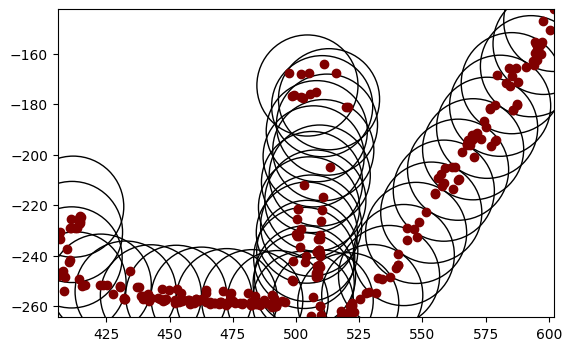

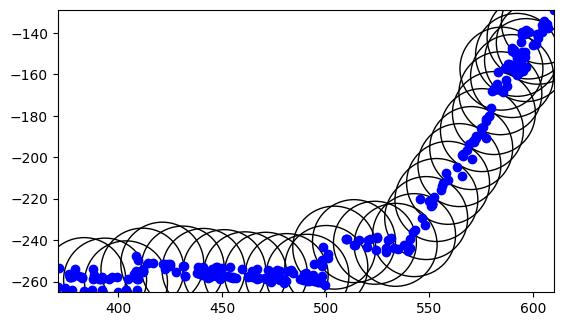

In [3]:
submap_centers, submaps, poses, times, submap_idxs = create_submaps([submap1_path, submap2_path], 
                                                                    submap_radius, 
                                                                    submap_center_dist, 
                                                                    show_maps=show_maps, 
                                                                    gt_pose_data=gt_pose_data, 
                                                                    rot_maps_to_gt=rotate_maps_to_gt)

In [4]:
def get_scaled_cos_score(v1, v2, cos_min, cos_max):
    print("Latent vector shape: ", v1.shape, v2.shape)
    cosscore = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    if cosscore <= cos_min:
        return 0.0
    if cosscore >= cos_max:
        return 1.0
    return (cosscore - cos_min) / (cos_max - cos_min)

In [5]:
def vis_association(submap_0, submap_1, association, T=np.eye(4)):
    # Prepare submaps for visualization
    ocd_list_0 = []
    ocd_list_1 = []
    edges = []
    red_color = np.asarray([1,0,0]).reshape((1,3))
    blue_color = np.asarray([0,0,1]).reshape((1,3))
    for seg in submap_0:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(seg.get_points())
        num_pts = seg.get_points().shape[0]
        rand_color = np.random.uniform(0, 1) * red_color
        rand_color = np.repeat(rand_color, num_pts, axis=0)
        pcd.colors = o3d.utility.Vector3dVector(rand_color)
        ocd_list_0.append(pcd)
        # print(pcd.get_center())

    for seg in submap_1:
        pcd = o3d.geometry.PointCloud()
        # pcd.points = o3d.utility.Vector3dVector(seg.get_points())
        pcd.points = o3d.utility.Vector3dVector(seg.get_points())
        pcd.transform(T)
        num_pts = seg.get_points().shape[0]
        rand_color = np.random.uniform(0, 1) * blue_color
        rand_color = np.repeat(rand_color, num_pts, axis=0)
        pcd.colors = o3d.utility.Vector3dVector(rand_color)
        pcd.translate(np.asarray([0,-30,0]))
        ocd_list_1.append(pcd)

    for obj_idx_0, obj_idx_1 in association:
        print(f'Add edge between {obj_idx_0} and {obj_idx_1}.')
        points = [ocd_list_0[obj_idx_0].get_center(), ocd_list_1[obj_idx_1].get_center()]
        line_set = o3d.geometry.LineSet(
            points=o3d.utility.Vector3dVector(points),
            lines=o3d.utility.Vector2iVector([[0,1]]),
        )
        line_set.colors = o3d.utility.Vector3dVector([[0,1,0]])
        # line_set.scale = 5
        # increase width
        edges.append(line_set)
    
    o3d.visualization.draw_geometries(ocd_list_0 + ocd_list_1 + edges)

In [9]:
sigma = 0.3
epsilon = 0.5
mindist=0.2
cos_min = 0.80
cos_max = 0.95
registration = DistSemanticSimReg(sigma=sigma, epsilon=epsilon, mindist=mindist, cos_feature_dim=768, cosine_min=cos_min, cosine_max=cos_max)
registration_semanticgrav = DistSemanticSimReg(sigma=sigma, epsilon=epsilon, mindist=mindist, cos_feature_dim=768, cosine_min=cos_min, cosine_max=cos_max, use_gravity=True)
registration_semanticgravw2 = DistSemanticSimReg(sigma=sigma, epsilon=epsilon, mindist=mindist, cos_feature_dim=768, cosine_min=cos_min, cosine_max=cos_max, use_gravity=True, distance_fusion_weight=2.0)
# registration_vol = DistVolReg(sigma=sigma, epsilon=epsilon, mindist=mindist)
# registration_semanticvol = DistSemanticSimReg(sigma=sigma, epsilon=epsilon, cos_feature_dim=768, mindist=mindist, volume=True, cosine_min=cos_min, cosine_max=cos_max)
registration_grav = DistOnlyReg(sigma=sigma, mindist=mindist, epsilon=epsilon, use_gravity=True)

In [6]:
submap0 = submaps[0]
submap1 = submaps[1]
### sparkal1 jackal2
# submap0_part = submap0[4]
# submap1_part = submap1[1]
### sparkal1 sparkal2
submap0_part = submap0[8]
submap1_part = submap1[-8]
print(len(submap0_part), len(submap1_part))

53 50


In [40]:
M, _, A_init = registration.get_MCA(submap0_part, submap1_part)
M_grav, _, A_grav_init = registration_grav.get_MCA(submap0_part, submap1_part)

In [7]:
print("FIRST SUBMAP")
for idx, obj in enumerate(submap0_part):
    print("Object idx in submap: ", idx, "Object id: ", obj._id)
print("SECOND SUBMAP")
for idx, obj in enumerate(submap1_part):
     print("Object idx in submap: ", idx, "Object id: ", obj._id)

FIRST SUBMAP
Object idx in submap:  0 Object id:  368
Object idx in submap:  1 Object id:  345
Object idx in submap:  2 Object id:  370
Object idx in submap:  3 Object id:  326
Object idx in submap:  4 Object id:  385
Object idx in submap:  5 Object id:  378
Object idx in submap:  6 Object id:  383
Object idx in submap:  7 Object id:  398
Object idx in submap:  8 Object id:  388
Object idx in submap:  9 Object id:  341
Object idx in submap:  10 Object id:  406
Object idx in submap:  11 Object id:  424
Object idx in submap:  12 Object id:  418
Object idx in submap:  13 Object id:  342
Object idx in submap:  14 Object id:  434
Object idx in submap:  15 Object id:  429
Object idx in submap:  16 Object id:  379
Object idx in submap:  17 Object id:  440
Object idx in submap:  18 Object id:  435
Object idx in submap:  19 Object id:  436
Object idx in submap:  20 Object id:  415
Object idx in submap:  21 Object id:  454
Object idx in submap:  22 Object id:  352
Object idx in submap:  23 Objec

In [10]:
# M, C, A_init = registration.get_MCA(submap0_part, submap1_part)
# for i in range(M.shape[0]):
#     for j in range(M.shape[1]):
#         if M[i, j] > 0 and i != j:
#             if (submap0_part[A_init[i, 0]]._id == 378 and submap1_part[A_init[i, 1]]._id == 1191) or (submap0_part[A_init[j, 0]]._id == 378 and submap1_part[A_init[j, 1]]._id == 1191):
#                 print(submap0_part[A_init[i, 0]]._id, submap1_part[A_init[i, 1]]._id)
#                 print(submap0_part[A_init[j, 0]]._id, submap1_part[A_init[j, 1]]._id)
#                 print(M[i, j])

In [10]:
associations = registration.register(submap0_part, submap1_part)
associations_semanticgrav = registration_semanticgrav.register(submap0_part, submap1_part)
associations_semanticgravw2 = registration_semanticgravw2.register(submap0_part, submap1_part)
# associations_vol = registration_vol.register(submap0_part, submap1_part)
# associations_semanticvol = registration_semanticvol.register(submap0_part, submap1_part)
associations_grav = registration_grav.register(submap0_part, submap1_part)

In [12]:
assoc_idx = 2
assoc = associations[assoc_idx]
obj0 = submap0_part[assoc[0]]
obj1 = submap1_part[assoc[1]]
print(obj0._id, obj1._id)
print(np.dot(obj0.semantic_descriptor, obj1.semantic_descriptor))
print(get_scaled_cos_score(obj0.semantic_descriptor, obj1.semantic_descriptor, cos_min, cos_max))
print(min(obj0.volume/obj1.volume, obj1.volume/obj0.volume))

604 1067
0.9614
Latent vector shape:  (768,) (768,)
1.0
0.4036498888413138


In [11]:
for assoc in associations:
    print("Association idices: ", assoc)
    print("Associated objects ids: ", submap0_part[assoc[0]]._id, submap1_part[assoc[1]]._id)

Association idices:  [1 5]
Associated objects ids:  345 1088
Association idices:  [29 20]
Associated objects ids:  484 1156
Association idices:  [5 6]
Associated objects ids:  378 1087
Association idices:  [25 25]
Associated objects ids:  469 1185
Association idices:  [40 37]
Associated objects ids:  530 1191
Association idices:  [20 14]
Associated objects ids:  415 1131
Association idices:  [14 13]
Associated objects ids:  434 1129
Association idices:  [35 29]
Associated objects ids:  511 1190
Association idices:  [49 47]
Associated objects ids:  563 1244
Association idices:  [43 41]
Associated objects ids:  550 1220
Association idices:  [15 15]
Associated objects ids:  429 1144


In [14]:
def get_M_entries(association, A):
    idxs = []
    for assoc in association:
        for i in range(A.shape[0]):
            if A[i][0] == assoc[0] and A[i][1] == assoc[1]:
                # print(A[i], assoc)
                idxs.append(i)
                break
    
    return idxs
def print_M_entries(M, idxs):
    M_sub = np.zeros((len(idxs), len(idxs)))
    for i in range(len(idxs)):
        for j in range(len(idxs)):
            M_sub[i, j] = M[idxs[i], idxs[j]]
            print(idxs[i], idxs[j], M[idxs[i], idxs[j]])
    return M_sub

In [15]:
# idxs = get_M_entries(associations, A_init)
# print_M_entries(M, idxs)

In [42]:
vis_association(submap0_part, submap1_part, associations, registration.T_align(submap0_part, submap1_part, associations))
# vis_association(submap0_part, submap1_part, associations)

Add edge between 29 and 31.
Add edge between 24 and 24.
Add edge between 4 and 13.
Add edge between 35 and 35.
Add edge between 7 and 12.
Add edge between 46 and 47.
Add edge between 33 and 32.
Add edge between 43 and 45.
Add edge between 39 and 43.
Add edge between 3 and 5.


In [17]:
# assoc_idx = 2
# assoc = associations[assoc_idx]
# obj0 = submap0_part[assoc[0]]
# obj1 = submap1_part[assoc[1]]
# print(obj0._id, obj1._id)
# print(np.dot(obj0.semantic_descriptor, obj1.semantic_descriptor))
# print(get_scaled_cos_score(obj0.semantic_descriptor, obj1.semantic_descriptor, cos_min, cos_max))
# print(min(obj0.volume/obj1.volume, obj1.volume/obj0.volume))

In [12]:
obj0 = submap0_part[13]
obj1 = submap1_part[25]
print(obj0._id, obj1._id)
print(np.dot(obj0.semantic_descriptor, obj1.semantic_descriptor))
print(get_scaled_cos_score(obj0.semantic_descriptor, obj1.semantic_descriptor, cos_min, cos_max))
print(min(obj0.volume/obj1.volume, obj1.volume/obj0.volume))

342 1185
0.967
Latent vector shape:  (768,) (768,)
1.0
0.26847657802540137


In [19]:
for assoc in associations_grav:
    print("Association idices: ", assoc)
    print("Associated objects ids: ", submap0_part[assoc[0]]._id, submap1_part[assoc[1]]._id)

Association idices:  [13 40]
Associated objects ids:  510 1057
Association idices:  [16 32]
Associated objects ids:  530 1039
Association idices:  [ 6 41]
Associated objects ids:  492 1079
Association idices:  [ 5 46]
Associated objects ids:  484 1087
Association idices:  [22 28]
Associated objects ids:  567 982
Association idices:  [ 7 47]
Associated objects ids:  489 1069
Association idices:  [19 31]
Associated objects ids:  550 1032


In [48]:
vis_association(submap0_part, submap1_part, associations_grav, registration_grav.T_align(submap0_part, submap1_part, associations_grav))
# vis_association(submap0_part, submap1_part, [[6, 41]], registration_grav.T_align(submap0_part, submap1_part, associations_grav))

# vis_association(submap0_part, submap1_part, associations_grav)

Add edge between 13 and 40.
Add edge between 16 and 32.
Add edge between 6 and 41.
Add edge between 5 and 46.
Add edge between 22 and 28.
Add edge between 7 and 47.
Add edge between 19 and 31.


In [36]:
idxs_grav = get_M_entries(associations_grav, A_grav_init)
print_M_entries(M_grav, idxs_grav)

703 703 1.0
703 848 0.9197386112279182
703 347 0.9384095444534
703 301 0.9252373215811428
703 1150 0.9880325496862179
703 404 0.9352499925693909
703 1000 0.5953291885617003
848 703 0.9197386112279182
848 848 1.0
848 347 0.9122912898445947
848 301 0.991681665927205
848 1150 0.8776210624730625
848 404 0.7499200739115653
848 1000 0.7195494026421618
347 703 0.9384095444534
347 848 0.9122912898445947
347 347 1.0
347 301 0.8776092862324234
347 1150 0.8436776965974985
347 404 0.7586994625114586
347 1000 0.6892524402634014
301 703 0.9252373215811428
301 848 0.991681665927205
301 347 0.8776092862324234
301 301 1.0
301 1150 0.9071777894321109
301 404 0.7119379321420995
301 1000 0.6150576324122877
1150 703 0.9880325496862179
1150 848 0.8776210624730625
1150 347 0.8436776965974985
1150 301 0.9071777894321109
1150 1150 1.0
1150 404 0.9441014291267402
1150 1000 0.42256795486380977
404 703 0.9352499925693909
404 848 0.7499200739115653
404 347 0.7586994625114586
404 301 0.7119379321420995
404 1150 0.9

array([[1.        , 0.91973861, 0.93840954, 0.92523732, 0.98803255,
        0.93524999, 0.59532919],
       [0.91973861, 1.        , 0.91229129, 0.99168167, 0.87762106,
        0.74992007, 0.7195494 ],
       [0.93840954, 0.91229129, 1.        , 0.87760929, 0.8436777 ,
        0.75869946, 0.68925244],
       [0.92523732, 0.99168167, 0.87760929, 1.        , 0.90717779,
        0.71193793, 0.61505763],
       [0.98803255, 0.87762106, 0.8436777 , 0.90717779, 1.        ,
        0.94410143, 0.42256795],
       [0.93524999, 0.74992007, 0.75869946, 0.71193793, 0.94410143,
        1.        , 0.37888904],
       [0.59532919, 0.7195494 , 0.68925244, 0.61505763, 0.42256795,
        0.37888904, 1.        ]])

In [33]:
obj0 = submap0_part[A_init[703][0]]
obj1 = submap1_part[A_init[703][1]]
print(obj0._id, obj1._id)
print(np.dot(obj0.semantic_descriptor, obj1.semantic_descriptor))
print(get_scaled_cos_score(obj0.semantic_descriptor, obj1.semantic_descriptor, cos_min, cos_max))
print(min(obj0.volume/obj1.volume, obj1.volume/obj0.volume))

510 1057
0.893
Latent vector shape:  (768,) (768,)
0.43554687500000033
0.0543365467121541


In [34]:
obj0 = submap0_part[A_init[347][0]]
obj1 = submap1_part[A_init[347][1]]
print(obj0._id, obj1._id)
print(np.dot(obj0.semantic_descriptor, obj1.semantic_descriptor))
print(get_scaled_cos_score(obj0.semantic_descriptor, obj1.semantic_descriptor, cos_min, cos_max))
print(min(obj0.volume/obj1.volume, obj1.volume/obj0.volume))

492 1079
0.843
Latent vector shape:  (768,) (768,)
0.0
0.1843954771399453


703 703 1.0
703 848 0.6076733413386982
703 347 0.0
703 301 0.6775992518552894
703 1150 0.0
703 404 0.628768313696503
703 1000 0.6989350973136365
848 703 0.6076733413386982
848 848 1.0
848 347 0.0
848 301 0.7412844065998098
848 1150 0.0
848 404 0.6481785943530914
848 1000 0.7997574501194169
347 703 0.0
347 848 0.0
347 347 1.0
347 301 0.0
347 1150 0.0
347 404 0.0
347 1000 0.0
301 703 0.6775992518552894
301 848 0.7412844065998098
301 347 0.0
301 301 1.0
301 1150 0.0
301 404 0.7111200463151411
301 1000 0.8587313812088707
1150 703 0.0
1150 848 0.0
1150 347 0.0
1150 301 0.0
1150 1150 1.0
1150 404 0.0
1150 1000 0.0
404 703 0.628768313696503
404 848 0.6481785943530914
404 347 0.0
404 301 0.7111200463151411
404 1150 0.0
404 404 1.0
404 1000 0.6928531825664314
1000 703 0.6989350973136365
1000 848 0.7997574501194169
1000 347 0.0
1000 301 0.8587313812088707
1000 1150 0.0
1000 404 0.6928531825664314
1000 1000 1.0


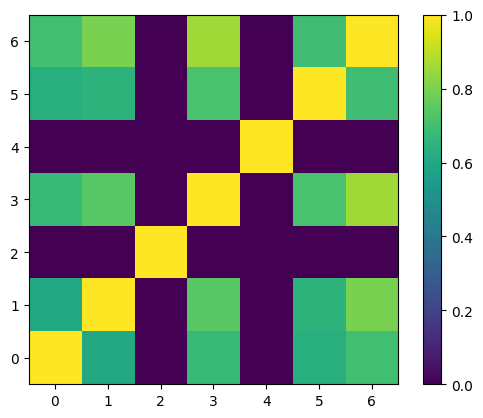

In [22]:
idxs = get_M_entries(associations_grav, A_init)
M_sub = print_M_entries(M, idxs)
plt.close()
plt.imshow(M_sub, vmin=M_sub.min(), vmax=M_sub.max(), interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

In [44]:
vis_association(submap0_part, submap1_part, associations_semanticgrav, registration_grav.T_align(submap0_part, submap1_part, associations_semanticgrav))


Add edge between 19 and 31.
Add edge between 18 and 34.
Add edge between 4 and 49.
Add edge between 16 and 32.
Add edge between 5 and 46.
Add edge between 49 and 18.
Add edge between 13 and 40.


In [47]:
vis_association(submap0_part, submap1_part, associations_semanticgravw2, registration_grav.T_align(submap0_part, submap1_part, associations_semanticgravw2))

Add edge between 19 and 31.
Add edge between 18 and 34.
Add edge between 16 and 32.
Add edge between 5 and 46.
Add edge between 4 and 49.
Add edge between 13 and 40.
Add edge between 7 and 47.


In [24]:
# for assoc in associations_semanticvol:
#     print("Association idices: ", assoc)
#     print("Associated objects ids: ", submap0_part[assoc[0]]._id, submap1_part[assoc[1]]._id)

In [25]:
# obj0 = submap0_part[21]
# obj1 = submap1_part[21]
# print(obj0._id, obj1._id)
# print(np.dot(obj0.semantic_descriptor, obj1.semantic_descriptor))
# print(min(obj0.volume/obj1.volume, obj1.volume/obj0.volume))

### Generate Similarity Matrix ###

In [26]:
# inlinear_pair_ids = np.asarray([
#                     [330, 1208],
#                     [352, 1159],
#                     [341, 1146],
#                     [342, 1153],
#                     [463, 1105]
#                      ])

# inlinear_pair_ids = np.asarray([
#                     [291, 1205],
#                     [275, 1239],
#                     [250, 1271],
#                     # [642, 928],
#                     [583, 917],
#                     [597, 964],
#                     [563, 1023],
#                     # [564, 1025],
#                     [488, 1032],
#                     [491, 1085],
#                     [478, 1098],
#                     # [465, 1105],
#                     [341, 1146],
#                     [1669, 242],
#                     # [1611, 504],
#                     # [1576, 359],
#                     [1568, 366],
#                     [1579, 387],
#                     [1533, 409],
#                     [1529, 403],
#                     [1451, 448],
#                     [1198, 653],
#                     [1167, 672],
#                     [1193, 678]
#                      ])

# inlinear_pair_idx_0 = []
# for idx in inlinear_pair_ids[:, 0]:
#     for i in range(len(submap0_part)):
#         if submap0_part[i]._id == idx:
#             print("Submap 0: ", idx)
#             inlinear_pair_idx_0.append(i)

# inlinear_pair_idx_1 = []
# for idx in inlinear_pair_ids[:, 1]:
#     for i in range(len(submap1_part)):
#         if submap1_part[i]._id == idx:
#             print("Submap 1: ", idx)
#             inlinear_pair_idx_1.append(i)

In [27]:
# print(inlinear_pair_idx_0[6], inlinear_pair_idx_1[6])

In [28]:
# M = np.zeros((len(inlinear_pair_idx_0), len(inlinear_pair_idx_1)))
# for i in range(len(inlinear_pair_idx_0)):
#     for j in range(len(inlinear_pair_idx_1)):
#         M[i, j] = np.dot(submap0_part[inlinear_pair_idx_0[i]].semantic_descriptor, submap1_part[inlinear_pair_idx_1[j]].semantic_descriptor)

# plt.close()
# plt.imshow(M, vmin=M.min(), vmax=M.max(), interpolation='nearest', origin='lower')
# plt.colorbar()
# plt.show()

In [29]:
# M = np.zeros((len(submap0_part), len(submap1_part)))
# for i, obj_i in enumerate(submap0_part):
#     for j, obj_j in enumerate(submap1_part):
#         M[i, j] = np.dot(obj_i.semantic_descriptor, obj_j.semantic_descriptor)


In [30]:
# M = np.zeros((len(associations), len(associations)))
# for i in range(len(associations)):
#     for j in range(len(associations)):
#         M[i, j] = np.dot(submap0_part[associations[i, 0]].semantic_descriptor, submap1_part[associations[j, 1]].semantic_descriptor)

In [31]:
# plt.close()
# plt.imshow(M, vmin=M.min(), vmax=M.max(), interpolation='nearest', origin='lower')
# plt.colorbar()
# plt.show()